# Muestra de neuroespora que son árboles y subgráficas conforme crecen
## Muestra 1
Graph 1 redes/Neurospora_crassa/Muestra1_M1N17h.gexf  es árbol  True

Graph 2 redes/Neurospora_crassa/Muestra1_M1N18h.gexf  es árbol  True

Son isomorfos True

Graph 1 redes/Neurospora_crassa/Muestra1_M1N18h.gexf  es árbol  True

Graph 2 redes/Neurospora_crassa/Muestra1_M1N20h.gexf  es árbol  True

Son isomorfos True

Graph 1 redes/Neurospora_crassa/Muestra1_M1N20h.gexf  es árbol  True

Graph 2 redes/Neurospora_crassa/Muestra1_M1N22h.gexf  es árbol  True

Son isomorfos True

Graph 1 redes/Neurospora_crassa/Muestra1_M1N22h.gexf  es árbol  True

Graph 2 redes/Neurospora_crassa/Muestra1_M1N24h.gexf  es árbol  False

Son isomorfos False

In [2]:
import networkx as nx
from networkx.algorithms import isomorphism
import os
import pandas as pd
import math
import constants as const
import heapq
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


In [3]:
def relabel_by_proximity(G, positions):
    """
    Reetiqueta los nodos de G con enteros del 0 a n-1 basándose en la distancia al origen (0,0).
    :param G: Grafo con nodos etiquetados por coordenadas.
    :param positions: Diccionario {nodo: (x, y)} con las posiciones de los nodos.
    :return: Grafo reetiquetado
    """
    # Ordenar nodos por distancia al origen
    sorted_nodes = sorted(positions.keys(), key=lambda node: math.dist((0, 0), positions[node]))
    mapping = {node: i for i, node in enumerate(sorted_nodes)}
    
    # Reetiquetar el grafo
    G_relabelled = nx.relabel_nodes(G, mapping, copy=True)
    return G_relabelled

In [4]:
def relabel_subgraph(G1, G2):
    """
    Encuentra la correspondencia de nodos entre G1 y G2, reetiqueta los nodos de G1
    según el isomorfismo y devuelve el mapeo junto con el nuevo grafo.
    :param G1: Grafo más pequeño (posible subgrafo)
    :param G2: Grafo más grande
    :return: Diccionario de reetiquetado y G1 reetiquetado si G1 es subgrafo de G2, None en caso contrario
    """
    GM = isomorphism.GraphMatcher(G2, G1)
    if GM.subgraph_is_isomorphic():
        mapping = next(GM.subgraph_isomorphisms_iter())
        mapeo = {v: k for k, v in mapping.items()}
        G1_relabelled = nx.relabel_nodes(G1, mapeo, copy=True)
        return G1_relabelled
    return None

In [5]:
def convert_prufer_to_tree(a):
    """
    Convierte una sucesión de Prüfer 'a' en un árbol.

    Parámetros:
      - a: lista de enteros que representa la sucesión de Prüfer.
           Se asume que los números en 'a' están en el rango 1..n+2,
           donde n = len(a).

    Retorna:
      - edges: lista de tuplas (u, v) representando las aristas del árbol.
    """
    n = len(a)               # La longitud de la sucesión de Prüfer
    N = n + 2                # El número total de nodos del árbol
    # Crear una lista para almacenar los grados de cada nodo.
    # Usamos un arreglo de tamaño N+1 para usar índices del 1 al N.
    degree = [0] * (N + 1)

    # Inicialmente, cada nodo tiene grado 1
    for i in range(1, N + 1):
        degree[i] = 1

    # Por cada elemento de la sucesión de Prüfer, se incrementa el grado del nodo correspondiente
    for val in a:
        degree[val] += 1

    edges = []  # Aquí se almacenarán las aristas del árbol

    # Para cada valor 'val' en la sucesión de Prüfer:
    for val in a:
        # Se busca el primer nodo (de menor índice) con grado 1
        for j in range(1, N + 1):
            if degree[j] == 1:
                # Se inserta la arista entre 'val' y 'j'
                edges.append((val, j))
                # Se actualizan los grados de ambos nodos
                degree[val] -= 1
                degree[j] -= 1
                # Se rompe el bucle ya que se encontró la hoja a conectar
                break

    # Al final, quedarán exactamente dos nodos con grado 1.
    # Se deben conectar estos dos nodos.
    u = v = 0
    for i in range(1, N + 1):
        if degree[i] == 1:
            if u == 0:
                u = i
            else:
                v = i
                break
    edges.append((u, v))
    degree[u] -= 1
    degree[v] -= 1

    return edges


In [6]:
def prufer_sequence_from_tree(edges):
    """
    Obtiene la sucesión de Prüfer de un árbol dado.

    Parámetros:
      - edges: lista de tuplas (u, v) que representan las aristas de un árbol etiquetado.

    Retorna:
      - prufer_seq: lista que representa la sucesión de Prüfer del árbol.
    """
    # 1. Determinar el conjunto de nodos y el número total de vértices.
    nodes = set()
    for u, v in edges:
        nodes.add(u)
        nodes.add(v)
    n = len(nodes)

    # 2. Crear la lista de adyacencia y calcular el grado de cada nodo.
    adj = {node: [] for node in nodes}
    degree = {node: 0 for node in nodes}

    for u, v in edges:
        adj[u].append(v)
        adj[v].append(u)
        degree[u] += 1
        degree[v] += 1

    # 3. Inicializar un heap (min-heap) con todas las hojas (nodos con grado 1)
    heap = []
    for node in nodes:
        if degree[node] == 1:
            heapq.heappush(heap, node)

    prufer_seq = []

    # 4. Realizar n-2 iteraciones para construir la sucesión de Prüfer.
    for _ in range(n - 2):
        # a) Extraer la hoja de menor etiqueta.
        leaf = heapq.heappop(heap)

        # b) Su hoja tendrá un único vecino; se toma el primer (y único) de su lista de adyacencia.
        neighbor = adj[leaf][0]
        prufer_seq.append(neighbor)

        # c) Actualizar el grado del vecino, eliminando la conexión con la hoja.
        degree[neighbor] -= 1
        adj[neighbor].remove(leaf)

        # d) La hoja se elimina del árbol; (podríamos marcarla con grado 0).
        degree[leaf] = 0

        # e) Si el vecino ahora es una hoja (grado 1), se agrega al heap.
        if degree[neighbor] == 1:
            heapq.heappush(heap, neighbor)

    return prufer_seq

In [7]:
def dibuja_arbol(G,pos):
# Colores
    
    # Normalizar las etiquetas de los nodos para que se ajusten al rango de 0 a 1
    norm = mcolors.Normalize(vmin=0, vmax=230)
    
    # Usar un mapa de colores continuo (por ejemplo, 'viridis', 'plasma', etc.)
    cmap = plt.cm.viridis
    
    # Asignar un color a cada nodo según su etiqueta utilizando el mapa de colores
    node_colors = [cmap(norm(node)) for node in G.nodes]

    # Configurar y mostrar la visualización
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_color=node_colors,
            edge_color="gray", node_size=500, font_size=12)
    #plt.title("Gráfica a partir de la sucesión de Prüfer")
    plt.axis("off")
    plt.show()

# Muestra 1
Usaremos las 4 primeras gráficas que cumplen con ser árboles y subgráficas conforme crece el isomorfismo

In [8]:
NET_PATH = "redes/Neurospora_crassa/"
MUESTRAS = 3

In [9]:
#probar si son subgrafos
files_net = [NET_PATH + f for f in os.listdir(NET_PATH) if '.gexf' in f]
files_net.sort()
nets = [nx.read_gexf(f) for f in files_net]
G_final =  nx.read_gexf(files_net[MUESTRAS])
positions = {n:(G_final.nodes[n]['x'], G_final.nodes[n]['y']) for n in G_final.nodes()}
G_final_relabelled = relabel_by_proximity(G_final, positions)
relabel_nets = [G_final_relabelled]
for i in [2,1,0]:
    G1 = nx.read_gexf(files_net[i])
    G2 = relabel_nets[-1]
    #Reetiqueta los nodos
    G_relabelled = relabel_subgraph(G1, G2)
    if G_relabelled:
        relabel_nets.append(G_relabelled)
        #print("Reetiquetado de nodos:", mapping)
        #print("G1 reetiquetado:", G1_relabelled.edges())
    else:
        print("G no es subgrafo de la ultima muestra")
relabel_nets.append(G_final_relabelled)

[2, 7, 10, 5, 14, 1, 12, 6, 19, 18, 24, 25, 28, 27, 31, 27, 30, 35, 38, 39, 35, 34, 46, 39, 40, 47, 62, 53, 51, 57, 57, 62, 58, 56, 67, 68, 75, 50, 58, 56, 14, 7, 4, 76, 69, 69, 19, 10, 5, 1, 0, 80, 67, 75, 78, 83, 70, 81, 88, 93, 110, 97, 97, 93, 53, 51, 50, 48, 105, 94, 88, 83, 80, 76, 74, 100, 106, 111, 110, 111, 114, 114, 117, 120, 106, 105, 103, 119, 123, 116, 134, 130, 130, 131, 136, 146, 141, 137, 146, 142, 143, 159, 144, 155, 152, 148, 160, 148, 136, 120, 94, 91, 160, 143, 134, 90, 152, 139, 162, 168, 168, 171, 190, 170, 174, 175, 141, 127, 182, 162, 137, 116, 81, 70, 68, 65, 174, 131, 123, 89, 195, 184, 170, 159, 119, 112, 175, 144, 100, 96, 190, 197, 154, 182, 165, 155, 118, 173, 195, 201, 184, 129, 186, 213, 202, 209, 207, 214, 207, 212, 217, 219, 217, 214, 213, 209, 202, 197, 171, 165, 139, 127, 118, 103, 91, 90, 74, 48, 46, 38, 30, 25, 18, 12, 6, 0, 2, 4, 24, 28, 31, 34, 40, 47, 65, 78, 89, 96, 112, 117, 129, 142, 154, 173, 186, 201, 211, 221, 222, 211, 212, 219, 221, 222]

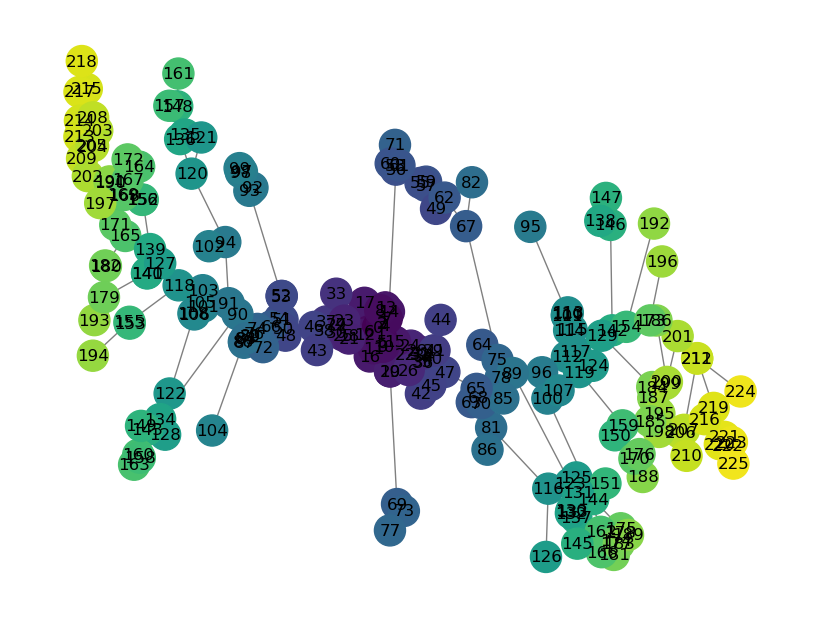

[2, 7, 5, 5, 1, 14, 1, 0, 12, 6, 18, 24, 25, 28, 30, 31, 34, 38, 40, 46, 47, 51, 51, 50, 14, 7, 4, 68, 75, 50, 48, 75, 76, 78, 76, 74, 70, 81, 94, 103, 100, 117, 81, 70, 68, 65, 103, 91, 120, 89, 119, 90, 136, 146, 100, 96, 146, 142, 148, 119, 112, 148, 136, 120, 94, 91, 90, 74, 48, 46, 38, 30, 25, 18, 12, 6, 0, 2, 4, 24, 28, 31, 34, 40, 47, 65, 78, 89, 96, 112, 117, 129, 129, 142, 154, 154, 173, 173, 186, 186]


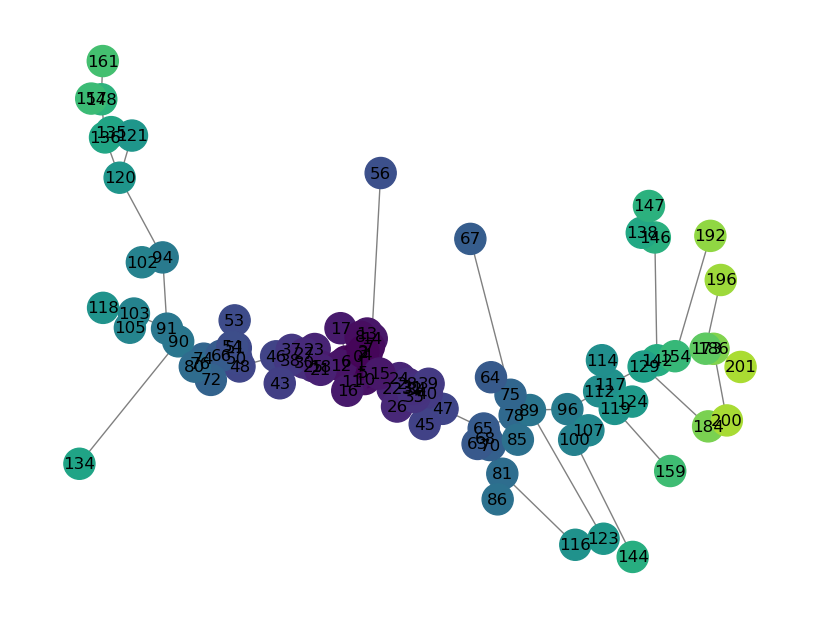

[2, 1, 4, 1, 0, 12, 6, 18, 24, 25, 28, 30, 31, 34, 38, 40, 46, 47, 48, 68, 76, 65, 76, 74, 70, 70, 68, 65, 47, 40, 34, 31, 28, 24, 4, 2, 0, 6, 12, 18, 25, 30, 38, 46, 48, 74, 90, 94, 91, 94, 91, 90]


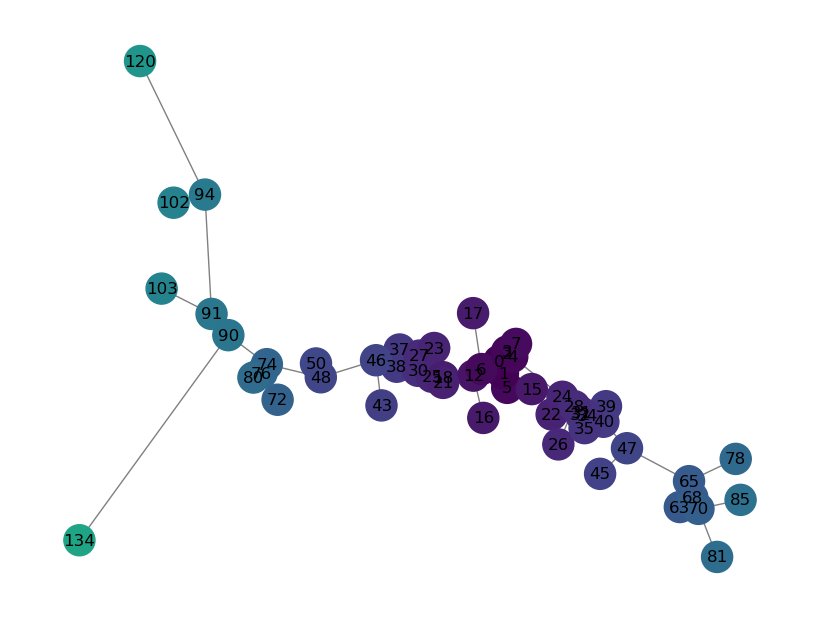

[2, 1, 4, 1, 0, 12, 6, 18, 24, 25, 28, 30, 31, 34, 38, 40, 46, 47, 48, 68, 68, 65, 48, 46, 38, 30, 25, 18, 12, 6, 0, 2, 4, 24, 28, 31, 34, 40, 47, 65]


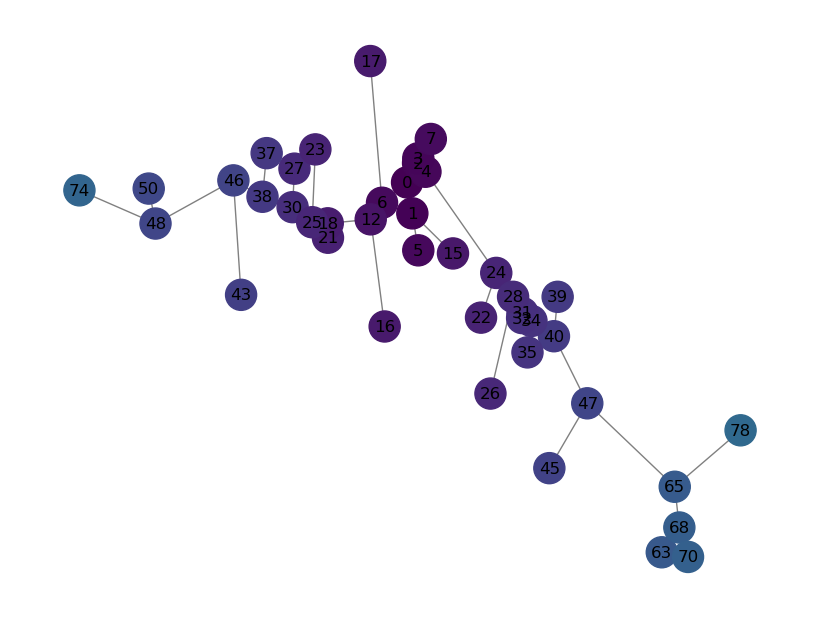

In [10]:
prufer_seq = list()
pos = {n:(relabel_nets[-1].nodes[n]['x'],relabel_nets[-1].nodes[n]['y']) for n in relabel_nets[-1].nodes()}
for G in relabel_nets[:-1]:
    ps = prufer_sequence_from_tree(G.edges())
    prufer_seq.append(ps)
    print(ps)
    dibuja_arbol(G,pos)

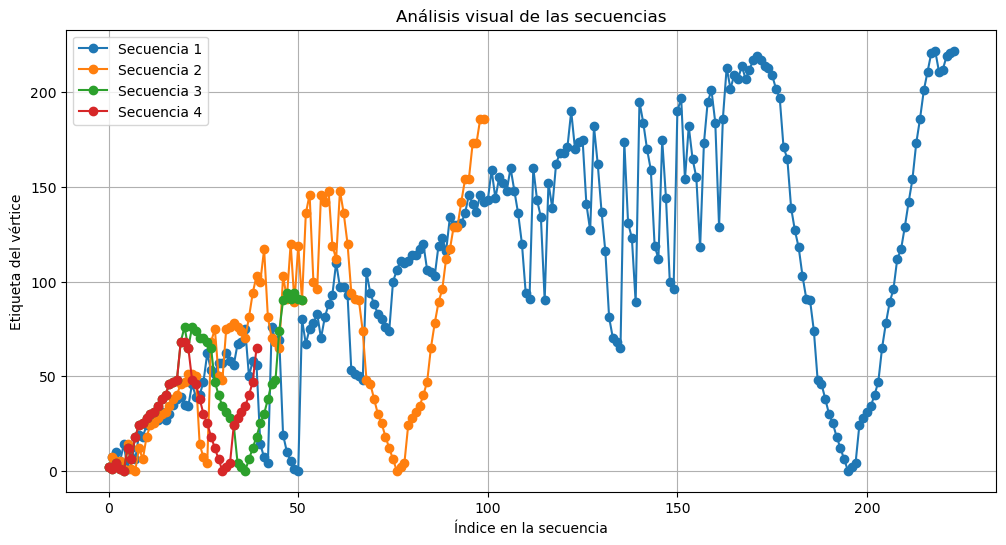

In [11]:
# Visualizar la evolución de las secuencias
plt.figure(figsize=(12, 6))
for i, seq in enumerate(prufer_seq):
    plt.plot(seq, label=f"Secuencia {i+1}", marker="o", linestyle="-")

plt.xlabel("Índice en la secuencia")
plt.ylabel("Etiqueta del vértice")
plt.title("Análisis visual de las secuencias")
plt.legend()
plt.grid()
plt.show()